In [2]:
import random
import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey
from collections import Counter


In [3]:
DICE = {
    'red': ['through ball/to yellow', 'inside pass/to blue', 'dribble/throw again', 'short pass/to black', 'through ball/to green', 'tackled and lost'],
    'black': ['pass back/to red', 'throw in/to blue', 'shoot', 'free kick/to yellow', 'long shot at goal', 'tackled and lost'],
    'blue': ['header at goal', 'shoot', 'opponent shown yellow card', 'pass back/to red', 'long shot at goal', 'tackled and lost'],
    'yellow': ['pass back/to black', 'off side', 'tackled and lost', 'penalty', 'shoot', 'shoot'],
    'green': ['goal', 'wide', 'goal', 'over bar', 'saved', 'corner/to yellow']
}


In [4]:
def roll_dice(color):
    return random.choice(DICE[color])


In [5]:
def play_turn(player, turn_data):
    color = 'red'
    score = 0

    while True:
        outcome = roll_dice(color)
        turn_data.append({'player': player, 'color': color, 'outcome': outcome})

        if 'tackled and lost' in outcome or outcome == 'off side':
            break
        elif 'goal' in outcome:
            score = 1
            break
        elif outcome in ['wide', 'over bar', 'saved']:
            break
        elif outcome == 'corner/to yellow':
            color = 'yellow'
            continue
        elif '/to ' in outcome:
            color = outcome.split('/to ')[1]
            color = color
            continue
        elif outcome in ['shoot', 'penalty', 'header at goal', 'long shot at goal']:
            color = 'green'
            continue
        elif outcome in ['dribble/throw again', 'opponent shown yellow card']:
            continue

    if color != 'green' and not any(end in outcome for end in ['tackled', 'off side']):
        final_outcome = roll_dice('green')
        turn_data.append({'player': player, 'color': 'green', 'outcome': final_outcome})
        if 'goal' in final_outcome:
            score = 1

    return score


In [6]:
def simulate_match():
    scores = {'A': 0, 'B': 0}
    current_player = 'A'
    turn = 0
    turn_data = []

    while turn < 30:
        player = f"Team {current_player}"
        score = play_turn(player, turn_data)
        scores[current_player] += score
        current_player = 'B' if current_player == 'A' else 'A'
        turn += 1
        if scores['A'] + scores['B'] >= 5:
            break

    return scores, turn_data


In [8]:
scores, turn_data = simulate_match()
print("Final Scores:", scores)
# Count flows between colors and outcomes
flows = Counter()

for i in range(len(turn_data)-1):
    src = turn_data[i]['color']
    dest = turn_data[i+1]['color'] if '/to ' in turn_data[i]['outcome'] or turn_data[i]['outcome'] in ['shoot', 'penalty', 'header at goal', 'long shot at goal', 'corner/to yellow'] else turn_data[i+1]['outcome']
    flows[(src, dest)] += 1

# Convert flows to Sankey inputs
labels = []
for pair in flows:
    for p in pair:
        if p not in labels:
            labels.append(p)

flow_values = []
flow_sources = []
flow_targets = []

for (src, dest), value in flows.items():
    flow_values.append(value)
    flow_sources.append(labels.index(src))
    flow_targets.append(labels.index(dest))

print("Sankey Labels:", labels)
print("Flow values:", flow_values)


Final Scores: {'A': 3, 'B': 2}
Sankey Labels: ['red', 'through ball/to green', 'green', 'dribble/throw again', 'inside pass/to blue', 'blue', 'through ball/to yellow', 'yellow', 'tackled and lost', 'short pass/to black', 'black']
Flow values: [1, 3, 1, 1, 6, 6, 4, 5, 6, 2, 2, 1, 3, 1, 2, 2, 1, 1, 1, 1, 1]


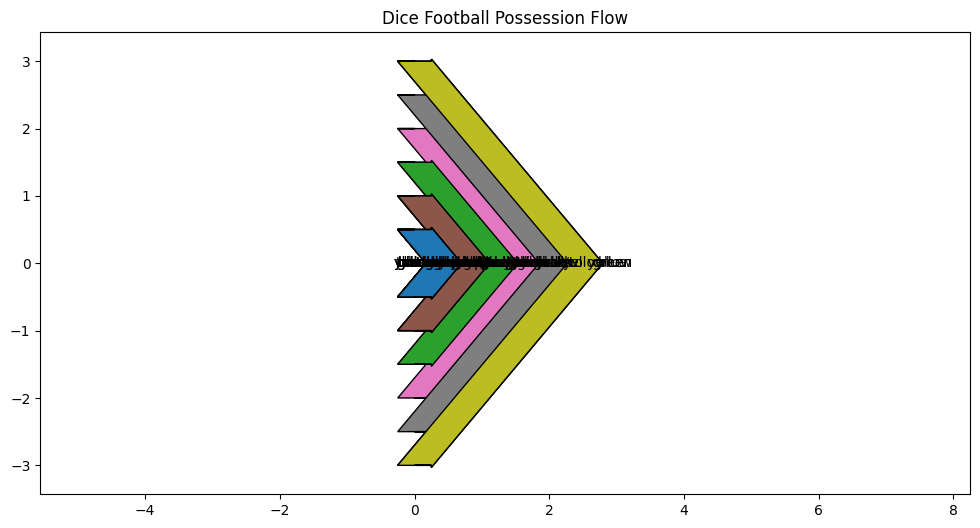

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
sankey = Sankey(ax=ax, unit=None)
for i in range(len(flow_values)):
    sankey.add(flows=[flow_values[i], -flow_values[i]],
               labels=[labels[flow_sources[i]], labels[flow_targets[i]]],
               orientations=[0, 0],
               trunklength=1.0)
sankey.finish()
plt.title("Dice Football Possession Flow")
plt.show()
